In [1]:
import numpy as np
import pandas as pd
import hvplot.pandas
import datetime
import requests
from dotenv import load_dotenv
import os
import yfinance as yf
import plotly.express as px
from scipy import optimize
import panel as pn
from panel.interact import interact
from panel import widgets
from pathlib import Path
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl


Bad key savefig.frameon in file /opt/anaconda3/envs/finance/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /opt/anaconda3/envs/finance/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /opt/anaconda3/envs/finance/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

# Risk Metric

In [2]:
# Read in Data 
btc_path = Path('BCHAIN-MKPRU.csv')
btc_df = pd.read_csv(btc_path,index_col="Date",infer_datetime_format=True, parse_dates=True)

# Split BTC prices to two periods for risk metric
btc_df = btc_df.iloc[::-1] # reverse df
dates = pd.to_datetime(btc_df.index)
btc_df_period_one = btc_df.iloc[750:2247] # period one data 01-22-2011 to 02-26-2015
btc_df_period_two = btc_df.iloc[1898:4605] # period two data 03-15-2014 - most recent date
btc_both_periods = pd.concat([btc_df_period_one,btc_df_period_two],axis='rows',join='inner', sort=False)

In [3]:
# Create 50day MA for period 1
fifty_day_ma = btc_df_period_one.rolling(window=50).mean()
fifty_day_ma.dropna(inplace=True)
fifty_day_ma.rename(columns={'Value':'50 Day'},inplace=True)

# Create 350Day MA for period 1
threehundredfifty_day_ma = btc_df_period_one.rolling(window=350).mean()
threehundredfifty_day_ma.dropna(inplace=True)
threehundredfifty_day_ma.rename(columns={'Value':'350 Day'},inplace=True)

# Concat 50day and 350 day, add Ratio column (50day / 350day)
ma_ratio_period_one = pd.concat([fifty_day_ma,threehundredfifty_day_ma],axis='columns',join='inner', sort=False)
ma_ratio_period_one['Ratio'] = ma_ratio_period_one['50 Day'] / ma_ratio_period_one['350 Day']

# Normalize data for period 1
ma_ratio_period_one= ma_ratio_period_one.apply(lambda x: (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0)))

In [4]:
# 50day MA for period 2
fifty_day_ma = btc_df_period_two.rolling(window=50).mean()
fifty_day_ma.dropna(inplace=True)
fifty_day_ma.rename(columns={'Value':'50 Day'},inplace=True)

# 350day ma for period 2
threehundredfifty_day_ma = btc_df_period_two.rolling(window=350).mean()
threehundredfifty_day_ma.dropna(inplace=True)
threehundredfifty_day_ma.rename(columns={'Value':'350 Day'},inplace=True)

# Concat 50day and 350 day, add Ratio column (50day / 350day)
ma_ratio_period_two = pd.concat([fifty_day_ma,threehundredfifty_day_ma],axis='columns',join='inner', sort=False)
ma_ratio_period_two['Ratio'] = ma_ratio_period_two['50 Day'] / ma_ratio_period_two['350 Day']

# Normalize period 2 data
ma_ratio_period_two = ma_ratio_period_two.apply(lambda x: (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0)))

In [5]:
# Concat period 1 and period 2 normalized ratios
ma_ratio_normalized = pd.concat([ma_ratio_period_one, ma_ratio_period_two],axis='rows',join='inner', sort=False)
ma_ratio_normalized.drop(['50 Day','350 Day'],axis=1, inplace=True)
ma_ratio_normalized.reset_index(inplace=True)

# Create df for "Values" of both periods
btc_both_periods_value = btc_both_periods.iloc[349:4198]
btc_both_periods_value.reset_index(inplace=True)

#merge with ma_ratio_normalized
btc_risk_merge = btc_both_periods_value.merge(ma_ratio_normalized,how='inner')
btc_risk_merge.set_index(btc_risk_merge['Date'], append=False, inplace=True)

/opt/anaconda3/envs/finance/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/finance/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/opt/anaconda3/envs/finance/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/opt/anaconda3/envs/finance/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Setting the 'color' property will override the edgecolo

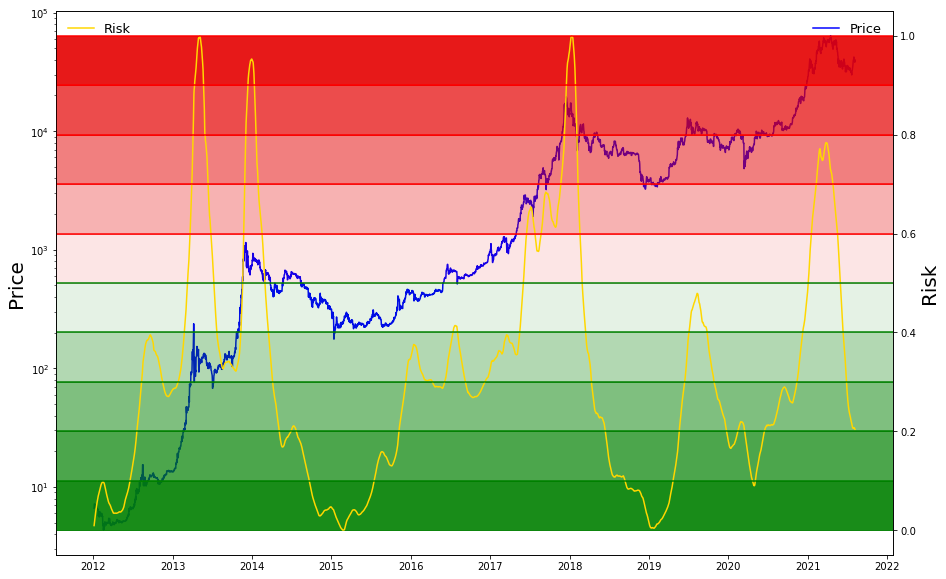

In [6]:
# Plot Risk Metric
risk,ax = plt.subplots(figsize=(15,10))
ax.semilogy(btc_risk_merge.Date,btc_risk_merge.Value, color='#0000FF', label='Price')

ax.set_ylabel("Price",color="black",fontsize=20)
ax2=ax.twinx()
ax2.set_ylabel("Risk",color="black",fontsize=20)

ax2.plot(btc_risk_merge.Date, btc_risk_merge["Ratio"], color="#FFD700", label='Risk')

ax.legend(frameon=False, loc='upper right',fontsize=13)
ax2.legend(frameon=False, loc='upper left',fontsize=13)


plt.axhline(y=0.1,color="green")
plt.axhline(y=0.2,color="green")
plt.axhline(y=0.3,color="green")
plt.axhline(y=0.4,color="green")
plt.axhline(y=0.5,color="green")
plt.axhline(y=0.6,color="red")
plt.axhline(y=0.7,color="red")
plt.axhline(y=0.8,color="red")
plt.axhline(y=0.9,color="red")
plt.axhline(y=1.0,color="red")
plt.axhspan(0.0, 0.10, facecolor='0.1', alpha=0.9,color='#008000')
plt.axhspan(0.1, 0.2, facecolor='0.2', alpha=0.7,color='#008000')
plt.axhspan(0.2, 0.3, facecolor='0.3', alpha=0.5,color='#008000')
plt.axhspan(0.3, 0.4, facecolor='0.4', alpha=0.3,color='#008000')
plt.axhspan(0.4, 0.5, facecolor='0.5', alpha=0.1,color='#008000')
plt.axhspan(0.5, 0.6, facecolor='0.5', alpha=0.1,color='#E50000')
plt.axhspan(0.6, 0.7, facecolor='0.4', alpha=0.3,color='#E50000')
plt.axhspan(0.7, 0.8, facecolor='0.3', alpha=0.5,color='#E50000')
plt.axhspan(0.8, 0.9, facecolor='0.2', alpha=0.7,color='#E50000')
plt.axhspan(0.9, 1.0, facecolor='0.1', alpha=0.9,color='#E50000')


NameError: name 'fig' is not defined

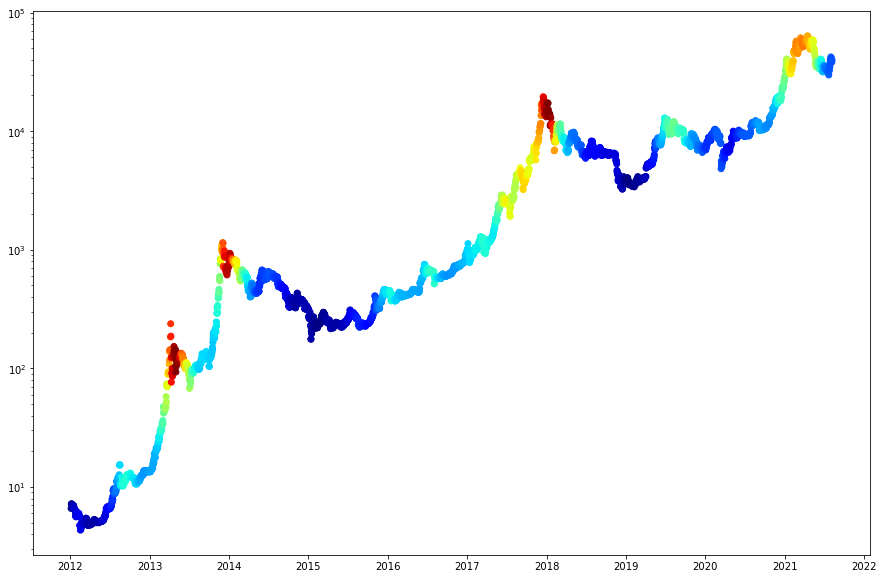

In [8]:
# Create Heatmap
dates = pd.to_datetime(btc_risk_merge.Date)

daily = btc_risk_merge[::1]                       
distance = daily['Ratio']
heatmap, ax = plt.subplots(figsize=(15,10))
ax.semilogy(dates, daily['Value'],color = 'white', zorder = 1,)
ax.scatter(daily['Date'], daily['Value'], c = distance, cmap='jet', vmin = 0, vmax = 1, zorder = 2)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0.0, vmax=1)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

#risk_label = plt.colorbar()
#risk_label.set_label("Risk",fontsize=20)

## disregard the fig error - code still running##

# Coin Metrics in Portfolio

In [9]:
# Fetch market data from Yfinance: 
def fetch_market_data(coins_list, start_date, end_date):
    '''Returns pd.DataFrame with the close for the given time-window and coins selected from yahoo finance API/database
  
    Parameters
    ----------
    coinds_list : list() - list of str() of coins we want to look at format must be by pair = coin-usd (example btc-usd)
    start_date : int() - string with date in following format YYYY-MM-DD
    end_date : int() - string with date in following format YYYY-MM-DD
    
    Returns
    -------
    coins_df : pd.DataFrame with list of coins and the close prices
  
    '''
    
    # Declare two pd.DataFrame
    coins_df = pd.DataFrame()
    temp_df= pd.DataFrame()
    
    # Creating the df by looping through the list of coins selected
    for i in coins_list:
        temp_df = yf.download(i,start= start_date,end= end_date)
        # Append temporary dataframe to result_df
        coins_df = pd.concat([coins_df, temp_df['Close']], axis= 1, join= "outer")
    
    # Rename the columns
    coins_df.columns= coins_list
    
    # send to CSV
    coins_df.to_csv('coins_prices_data.csv')
   
    return coins_df


In [10]:
coins_list= ['btc-usd','eth-usd','dot1-usd','ada-usd','matic-usd', 'enj-usd','mana-usd']
coins_df= fetch_market_data(coins_list,'2021-01-01', '2021-08-31')
#no_index_df = coins_df.reset_index(inplace=True)
#no_index_df.rename(columns={'index': 'Date'}, inplace=True)
coins_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,btc-usd,eth-usd,dot1-usd,ada-usd,matic-usd,enj-usd,mana-usd
2021-01-01,29374.152344,730.367554,8.306819,0.175350,NaN,NaN,NaN
2021-01-02,32127.267578,774.534973,9.208837,0.177423,NaN,NaN,NaN
2021-01-03,32782.023438,975.507690,10.033283,0.204995,NaN,NaN,NaN
2021-01-04,31971.914062,1040.233032,9.469611,0.224762,NaN,NaN,NaN
2021-01-05,33992.429688,1100.006104,9.701656,0.258314,NaN,NaN,NaN


In [11]:
## Metrics : 

def coins_marketdata_metrics(df_data, start_date, end_date, coins):
    ''' This fonction Returns pd.DataFrame containing the below list of markets metrics that the funtion is calculating
    for each coins selected.
    
    List of metrics that the fucntion calculates :  
        1. Annualized Return
        2. Normalized ROI - Cumulative Returns
        3. Riskiness of the coins -  annualized Volatility
        4. Risk flag - exponetial moving standard variation (7 days) above or below the Simple Moving Standard Variation (30 days)
        5. Max drawdown function
        6. Date of the max drawdown
        7. 30 days trend return
        8. Sharp ratio
        
    Parameters
    ----------
    df_data : DataFrame() - containing list of coins with close prices
    coinds_list : list() - list of str() of coins we want to look at format must be by pair = coin-usd (example btc-usd)
    start_date : int() - string with date in following format YYYY-MM-DD
    end_date : int() - string with date in following format YYYY-MM-DD
    
    Returns
    -------
    coins_df : pd.DataFrame with the list of markets metrics calculated by the function 
  
    '''
    # filter the coins we want to apply the calculation from the market_data df
    filtered_df= df_data[coins]

    # calculate daily returns:
    daily_returns= coins_df.pct_change().dropna()

    # calculate daily standard deviation
    daily_std= daily_returns.std()

                                ###### Calculate the metrics ######


    # Metric 1: Annualized Return: 
    annualized_returns= daily_returns.mean() * 252 

    # Metric 2:  Normalized ROI 
    # calculate cumulative returns compound
    roi_df = (1 + daily_returns).cumprod()-1

    # Metric 3: Riskiness of the coins selected -  annualized Volatility
    # Use the `std` function and multiply by the square root of the number of trading days in a year to get annualized volatility
    volatility= daily_std * np.sqrt(252)

    # Metric 4: Risk flag - exponetial moving standard variation (7 days) above or below 
        # the Simple Moving Standard Variation (30 days)
    # calculate simple moving average STD which we will be using as a benchmark
    rolling_std_ref= daily_returns.rolling(window=30).std()
    rolling_std_last= rolling_std_ref.iloc[-1]
    # calculate exponential rolling std using 
    ewm_std = daily_returns.ewm(halflife=7).std()
    ewm_std_last= ewm_std.iloc[-1]

    vol_flag= ewm_std_last > rolling_std_last
    vol_flag= vol_flag.replace([True, False], ['High', 'Low'])

    # Metric 5: Max drawdown function
    cumulative_returns = (1+ daily_returns).cumprod()
    previous_peaks = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - previous_peaks)/previous_peaks
    mdd= round(drawdowns.min()*100,2)
    mdd_date= drawdowns.idxmin()

    mdd_df= pd.DataFrame({
        'mdd':mdd,
        'mdd_date':mdd_date
    })

    # Metric 6: 30 days trend return
    trend= ((coins_df.iloc[-1])/ (coins_df.iloc[-31]))-1

    # Metric 7 : Sharp ratio
    sharp_ratios = (daily_returns.mean() * 252) / (daily_std * np.sqrt(252))



                                ###### CReate the final DataFrame ###### 

    # Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
    coins_metrics_df = pd.DataFrame({
        'Annual Return':annualized_returns,
        '30 days trend':trend,
        'Cumulative Returns':roi_df.iloc[-1],
        'Annual Volatility':volatility,
        'Risk Flag': vol_flag,
        'Max Draw Down': mdd_df['mdd'],
        'Date Max Draw Down':mdd_df['mdd_date'],
        'Sharp Ratio': sharp_ratios,
    })

    return coins_metrics_df

In [12]:
# Run the function: 
coins= ['dot1-usd','ada-usd','matic-usd', 'enj-usd','mana-usd']
start_date= '2021-04-01'
end_date= '2021-08-31'
coins_metrics_df= pd.DataFrame()
coins_metrics_df= coins_marketdata_metrics(coins_df, start_date, end_date, coins)
coins_metrics_df

,Annual Return,30 days trend,Cumulative Returns,Annual Volatility,Risk Flag,Max Draw Down,Date Max Draw Down,Sharp Ratio
btc-usd,-0.137391,0.179908,-0.201861,0.687727,Low,-53.06,2021-07-20,-0.199776
eth-usd,1.400730,0.340332,0.736597,0.979961,Low,-57.12,2021-07-20,1.429373
dot1-usd,0.559580,0.709030,-0.164650,1.288393,High,-77.10,2021-07-20,0.434324
ada-usd,2.017244,1.103978,1.331292,1.113153,High,-54.26,2021-07-20,1.812189
matic-usd,3.731790,0.271389,2.673869,1.881872,Low,-71.88,2021-07-20,1.983020
enj-usd,0.772926,0.466994,-0.205605,1.553007,High,-73.55,2021-06-22,0.497696
mana-usd,0.738475,0.370865,-0.079768,1.321290,High,-72.14,2021-06-22,0.558905


In [13]:
# Sharpe ratio plot
sharpe_ratio = coins_metrics_df['Sharp Ratio']
sharpe_plot = sharpe_ratio.hvplot.bar(ylabel="Sharpe Ratio",width=1000, height=500)

# ROI plot
daily_returns= coins_df.pct_change().dropna()
roi_df = (1 + daily_returns).cumprod()-1
roi_df_normalized = roi_df.apply(lambda x: (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0)))
roi_dict = roi_df_normalized.to_dict()
x = pn.widgets.Select(name='Coins',options=roi_dict)
roi_plot = roi_df.hvplot.line(ylabel='Normalized Price', xlabel='Date',width=1000, height=500)

# calculate daily standard deviation
#daily_std= daily_returns.std()
roi_plot

#roi_df_normalized['eth-usd'],roi_df_normalized['dot1-usd'],roi_df_normalized['ada-usd'],roi_df_normalized['matic-usd'],roi_df_normalized['enj-usd'],roi_df_normalized['mana-usd'])


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [15]:
coins_df.head()

,btc-usd,eth-usd,dot1-usd,ada-usd,matic-usd,enj-usd,mana-usd
2021-01-01,29374.152344,730.367554,8.306819,0.175350,NaN,NaN,NaN
2021-01-02,32127.267578,774.534973,9.208837,0.177423,NaN,NaN,NaN
2021-01-03,32782.023438,975.507690,10.033283,0.204995,NaN,NaN,NaN
2021-01-04,31971.914062,1040.233032,9.469611,0.224762,NaN,NaN,NaN
2021-01-05,33992.429688,1100.006104,9.701656,0.258314,NaN,NaN,NaN


In [16]:
#daily std in charts
#import hvplot.pandas

#annualized_std = (daily_std * np.sqrt(252)).sort_values(ascending=False)#.axhline(color='black', linewidth=2)

#volatility_plot = annualized_std.plot()
#x = pn.widgets.Select(name='Asset', options=[tickers])
#df_closing_normalized.hvplot.line(ylabel="Normalized Price", xlabel="Date")

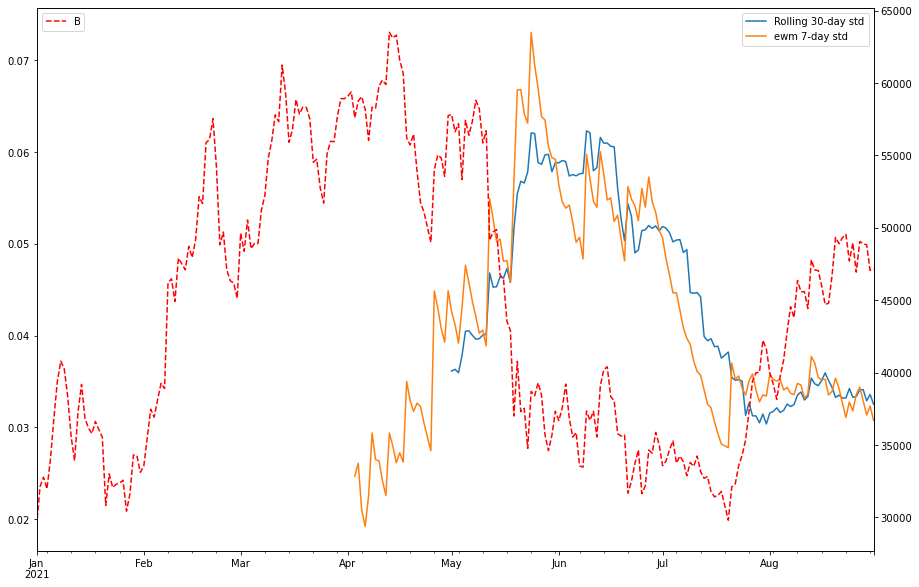

In [17]:
   ########## Explain the Vol_Flag#######
    
    # calculate daily returns:
daily_returns= coins_df.pct_change().dropna()
 
    # calculate daily standard deviation
daily_std= daily_returns.std()

rolling_std_ref= daily_returns['btc-usd'].rolling(window=30).std()
# calculate exponential rolling std using 
ewm_std = daily_returns['btc-usd'].ewm(halflife=7).std()
prices= coins_df['btc-usd']
flag, ax = plt.subplots(figsize=(15,10))
ax = rolling_std_ref.plot()
ewm_std.plot(figsize=(15,10), ax=ax)
ax.legend(['Rolling 30-day std', 'ewm 7-day std'])
ax2= ax.twinx()
ax2= prices.plot(color='red',linestyle='--')
ax2.legend('BTC prices',loc=2)


In [18]:
# Volatility Signal Column
vol_signal = coins_metrics_df['Risk Flag'],coins_metrics_df['Max Draw Down'], coins_metrics_df['Date Max Draw Down']
vol_signal_df = pd.DataFrame(vol_signal)
df_transposed = vol_signal_df.T
df_transposed[['Date Max Draw Down']] = df_transposed[['Date Max Draw Down']].apply(pd.to_datetime)
df_transposed

,Risk Flag,Max Draw Down,Date Max Draw Down
btc-usd,Low,-53.06,2021-07-20
eth-usd,Low,-57.12,2021-07-20
dot1-usd,High,-77.1,2021-07-20
ada-usd,High,-54.26,2021-07-20
matic-usd,Low,-71.88,2021-07-20
enj-usd,High,-73.55,2021-06-22
mana-usd,High,-72.14,2021-06-22


# Dashboard

In [19]:
risk_metric_col = pn.Column('## BTC Risk', risk)
heatmap_col = pn.Column('## BTC Heatmap', heatmap)
roi_col = pn.Column('## ROI', roi_plot)
vol_flag_col = pn.Column('## Volatility Flag', flag)
vol_signal_col = pn.Column('## Volatility signals', df_transposed)
sharpe_ratio_col = pn.Column('## Sharpe Ratio', sharpe_plot)

#portfolio_close_col = pn.Column('## Portfolio Close Data', portfolios_plot_close_data)
#portfolio_cumulative_col = pn.Column('## Portfolio Cumulative Returns', portfolios_plot_cumulative_data)

btc_risk_tabs = pn.Tabs(
    ('BTC Risk', risk_metric_col),
    ('BTC Heatmap', heatmap_col)
)

coin_metrics_tabs = pn.Tabs(
    ('ROI', roi_col),
    ('Sharpe Ratio', sharpe_ratio_col)
    # MISSING VOLATILITY COL
)

volatility_flag_tab = pn.Tabs(
    ('Vol Flag', vol_flag_col),
    ('Vol Flag Signal', df_transposed)
)

mainTabs = pn.Tabs(
    ('BTC Risk Metric', btc_risk_tabs),
    ('Coin Metrics', coin_metrics_tabs),
    ('Volatility Flag Metrics', volatility_flag_tab)
)

dashboard = pn.Column('# My Portfolio Tools', mainTabs)

In [21]:
dashboard.show()

Launching server at http://localhost:54218
